## Vertical Spectra

Vertical spectra of tracers in the ocean are not usually considered, here we look at them. This follows some of the reasoning from Smith and Ferrari 09, where the horizontal-vertical spectra were computed.


In [1]:
from scipy.io import loadmat
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import xrft 

import gsw

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
ds_660_rho = xr.open_dataset('data/ctd_660_isopycnal_grid_4m_26_july_2021.nc')

# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha = 8e-5
beta  = 77.4e-5

# remove a mean per isopycnal
dCT = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

ds_660_rho['Spice'] = (alpha*dCT + beta*dSA).rename('Spice')

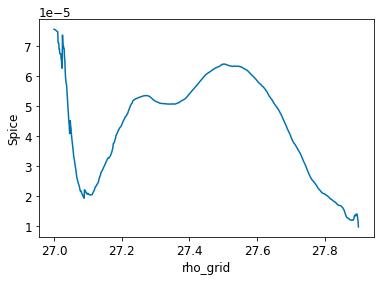

In [4]:
ds_660_rho['Spice'].std('dives').plot()

In [5]:
ds_660_rho

<xarray.Dataset>
Dimensions:       (dives: 1007, rho_grid: 901)
Coordinates:
  * rho_grid      (rho_grid) float64 27.0 27.0 27.0 27.0 ... 27.9 27.9 27.9 27.9
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    ctd_pressure  (rho_grid, dives) float64 ...
    CT            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    SA            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    latitude      (rho_grid, dives) float64 ...
    longitude     (rho_grid, dives) float64 ...
    days          (rho_grid, dives) float64 ...
    Spice         (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan

### Go back to Z grid

There are a few options on how to do this:
- Back to the original Z grid (this only requires us to reinterpolate spice, since we already have the other things on that grid. 
- A low pass version of Z (this will require to time filter out some high freq variability)
- A mean Z (the issue with this is that density range changed quite a bit b/w the experiment, and we might have to throw out a lot of data at the edges). 

#### Zeroth approach: 
Use conservative temperature directly, as it seems to look like a passive tracer visually. Then convert from z to ztilde. 

In [6]:
ds_660_grid = xr.open_dataset('data/ctd_660_vert_4m_binned_29_june_2021.nc')
# Calculate a time axis as YTD
days = ds_660_grid.time - np.datetime64('2019-01-01')
days_round_660 = (days / np.timedelta64(1, 'D')).round()
ds_660_grid['days'] = (days / np.timedelta64(1, 'D'))

In [7]:
# Practically define tilde as the average
rho_tilde = ds_660_grid.sigma0.mean('dives')
rho_prime = ds_660_grid.sigma0 - rho_tilde

In [8]:
g = 9.81
rho_0 = 1000
b_tilde = - (g*rho_tilde/rho_0).rename('b_tilde')
b_prime = - (g*rho_prime/rho_0).rename('b_prime')
N2 = (b_tilde.diff('ctd_pressure') / (-b_tilde.ctd_pressure).diff('ctd_pressure')).rename('N2')
# need '-' as the Z should be increasing towards the surface

Charney's vertical rescaling for QG is 
$$
d\tilde{z} = \frac{N}{f} dz
$$


For simplicity let's just apply it directly to CT, which is very similar looking to Spice (atleast at the largest scales).

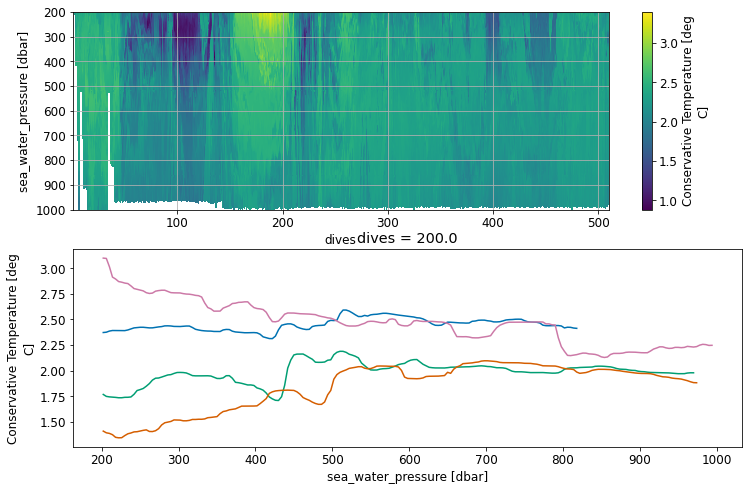

In [9]:
plt.figure(figsize=(12,8))

plt.subplot(211)
ds_660_grid.CT.sel(ctd_pressure=slice(200,1000)).plot()
plt.grid()
plt.gca().invert_yaxis()

plt.subplot(212)
ds_660_grid.CT.sel(ctd_pressure=slice(200,1000)).sel(dives=40).plot()
ds_660_grid.CT.sel(ctd_pressure=slice(200,1000)).sel(dives=80).plot()
ds_660_grid.CT.sel(ctd_pressure=slice(200,1000)).sel(dives=120).plot()
ds_660_grid.CT.sel(ctd_pressure=slice(200,1000)).sel(dives=200).plot()

In [10]:
dz = ds_660_grid.ctd_pressure.diff('ctd_pressure').mean() # 4m
N = N2.rolling(ctd_pressure=10, center=True).mean()**0.5 # do a little smoothing
f = np.abs(2*2*np.pi/24/3600*np.sin(-51*np.pi/180))
dz_tilde = dz*N/f

z_tilde = np.cumsum(dz_tilde)

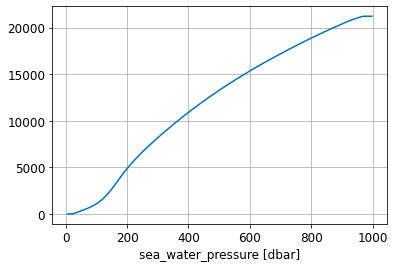

In [11]:
z_tilde.sel(ctd_pressure = slice(0, 1000)).plot()
plt.grid()

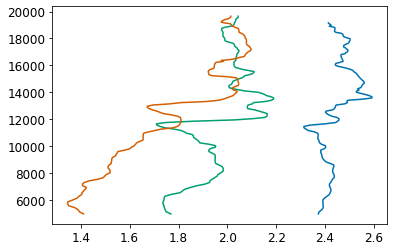

In [12]:
plt.plot(ds_660_grid.CT.sel(ctd_pressure=slice(200,850)).sel(dives=40), 
         z_tilde.sel(ctd_pressure=slice(200,850)))
plt.plot(ds_660_grid.CT.sel(ctd_pressure=slice(200,850)).sel(dives=80), 
         z_tilde.sel(ctd_pressure=slice(200,850)))
plt.plot(ds_660_grid.CT.sel(ctd_pressure=slice(200,850)).sel(dives=120), 
         z_tilde.sel(ctd_pressure=slice(200,850)))


In [13]:
from scipy import interpolate

In [14]:
# Interpolate from z to z_tilde 
dive_num = 400
#z = ds_660_grid.ctd_pressure
z_tilde_sel = z_tilde.sel(ctd_pressure=slice(200, 900))
y = ds_660_grid.CT.sel(dives=dive_num).sel(ctd_pressure=slice(200, 900))

z_tilde_grid = np.arange(z_tilde_sel.min(), z_tilde_sel.max(), 
                           dz_tilde.sel(ctd_pressure=slice(200,900)).min() )

f = interpolate.PchipInterpolator(z_tilde_sel, y)
y_tilde = f(z_tilde_grid)

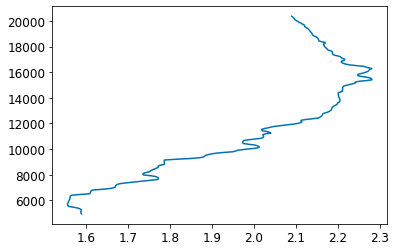

In [15]:
plt.plot(y_tilde, z_tilde_grid)

In [16]:
def func_var_ztilde_int(ds, var):
    
    dep_slice = slice(200, 900)
    dive_num = ds['dives'].values
    
    y_sel = ds_660_grid[var].sel(dives=dive_num).sel(ctd_pressure = dep_slice)
    y_nonan = y_sel.where(~np.isnan(y_sel), drop=True)
    
    z_tilde_sel = z_tilde.sel(ctd_pressure = dep_slice)
    z_tilde_nonan = z_tilde_sel.where(~np.isnan(y_sel), drop=True)
    
    z_tilde_grid = np.arange(z_tilde_sel.min(), 
                             z_tilde_sel.max(), 
                             dz_tilde.sel(ctd_pressure=dep_slice).min() )
    
    
    
    if len(y_nonan)>2:
        f = interpolate.PchipInterpolator(z_tilde_nonan, y_nonan, extrapolate=False)
    
        y_tilde_sel = f(z_tilde_grid)
    else:
        y_tilde_sel = np.nan*z_tilde_grid
    
    return xr.DataArray(y_tilde_sel.reshape(-1, 1), 
                          dims = ['z_tilde', 'dives'],
                          coords = {'z_tilde': z_tilde_grid, 'dives': [dive_num]} )

In [17]:
dive_ind = 0

CT_tilde_xr = func_var_ztilde_int(ds_660_grid.isel(dives=dive_ind), 'CT')

for dive_ind in range(1, len(ds_660_grid.dives)):
    if np.mod(dive_ind, 100)==0:
        print(dive_ind)
    CT_tilde_xr = xr.concat([CT_tilde_xr , func_var_ztilde_int(ds_660_grid.isel(dives=dive_ind), 'CT')], dim='dives')
    
    

100
200
300
400
500
600
700
800
900
1000


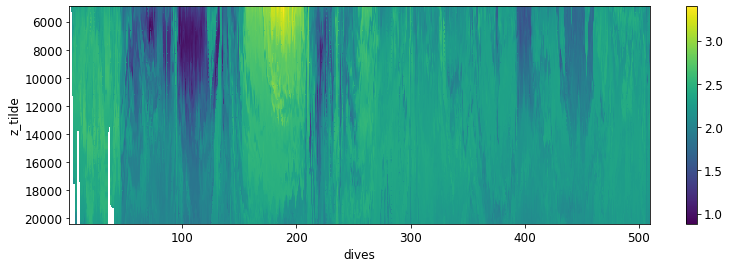

In [18]:
plt.figure(figsize=(13, 4))
CT_tilde_xr.plot()
plt.gca().invert_yaxis()

In [19]:
import xrft

In [20]:
CT_spec_ztilde = xrft.power_spectrum(CT_tilde_xr.dropna(dim='dives') - CT_tilde_xr.mean('dives'),
                                     dim='z_tilde', window=True)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


Text(0.5, 0, '$\\lambda$ [1/m]')

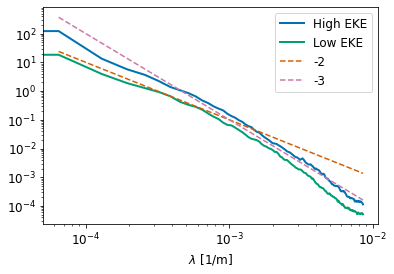

In [21]:
CT_spec_ztilde.sel(dives=slice(0,250)).mean('dives').plot(label='High EKE', linewidth=2)
CT_spec_ztilde.sel(dives=slice(250,500)).mean('dives').plot(label='Low EKE', linewidth=2)

kz = CT_spec_ztilde.freq_z_tilde

plt.plot(kz, 1e-7*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-10*kz**(-3), '--', label='-3')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

Text(0.5, 0, '$\\lambda$ [1/m]')

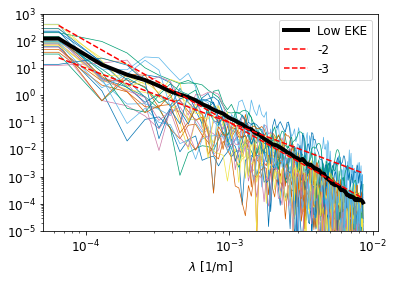

In [22]:
for i in range(1,250,10):
    CT_spec_ztilde.sel(dives=i, method='nearest').plot(linewidth=.7)
CT_spec_ztilde.sel(dives=slice(0,250)).mean('dives').plot(label='Low EKE', linewidth=4, color='k')

kz = CT_spec_ztilde.freq_z_tilde

plt.plot(kz, 1e-7*kz**(-2), '--', label='-2', color='r')
plt.plot(kz, 1e-10*kz**(-3), '--', label='-3', color='r')

plt.legend()
plt.ylim([1e-5, 1e3])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

The vertical spectra shown above is a new metric, which has not been presented before. 
Here is our naive interpretation, but more work needs to be done. 

- The slope at large scales, larger than equivalent 2km, is similar to what is observed at horizontal scales with a slope of -2. 
- At smaller scales the slope is even steeper, with -3 slope. This is suggestive that there are small submesoscales active in the interior. 
- Changing from z to $\tilde{z}$ did not change things much here because the change in N is gentle. 

#### First approach

Take spice from density to depth space first, then do above analysis on it. 

Convert from z to ztilde. 

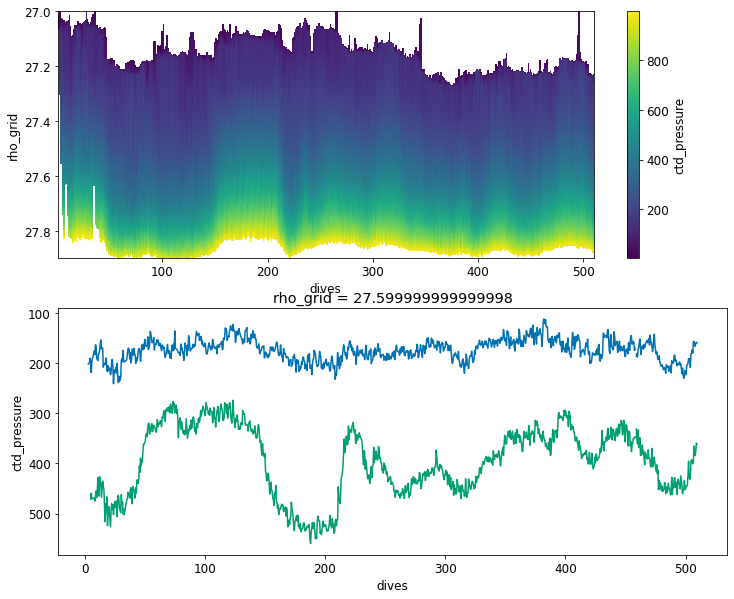

In [23]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
ds_660_rho.ctd_pressure.plot()
plt.gca().invert_yaxis()

plt.subplot(212)
ds_660_rho.ctd_pressure.sel(rho_grid=27.3, method='nearest').plot()
ds_660_rho.ctd_pressure.sel(rho_grid=27.6, method='nearest').plot()
plt.gca().invert_yaxis()


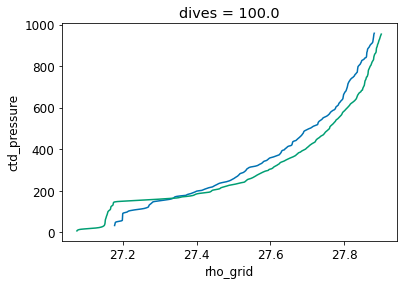

In [24]:
ds_660_rho.ctd_pressure.sel(dives=50).plot()
ds_660_rho.ctd_pressure.sel(dives=100).plot()


In [25]:
z_grid = ds_660_grid.ctd_pressure.values
def func_var_int_rho_to_z(ds, var = 'Spice'): 
    dive_num = ds['dives'].values 
    
    z = ds.ctd_pressure
    
    z_nonan = z.where(~np.isnan(z), drop=True)
    
    var_nonan = ds[var].where(~np.isnan(z), drop=True)
    
    if len(z_nonan)>2: 
        fvar = interpolate.PchipInterpolator(z_nonan, var_nonan, extrapolate=False)
        
        var_z = fvar(z_grid)
        
    else:
        var_z = np.nan*z_grid
        
    return xr.DataArray(var_z.reshape((-1,1)), 
                        dims = ['ctd_pressure', 'dives'],
                        coords = {'ctd_pressure': z_grid, 'dives': [dive_num]}).rename(var)
        

In [26]:
dive_ind = 0
spice_z_xr= func_var_int_rho_to_z(ds_660_rho.isel(dives=dive_ind), 'Spice')

for dive_ind in range(1, len(ds_660_rho.dives)):
    spice_z_xr= xr.concat([spice_z_xr, func_var_int_rho_to_z(ds_660_rho.isel(dives=dive_ind), 'Spice')], 
                         dim='dives')
    

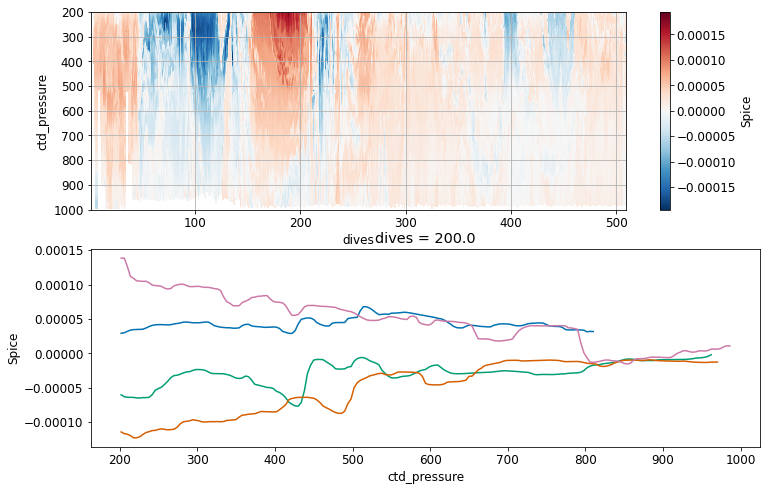

In [27]:
plt.figure(figsize=(12,8))

plt.subplot(211)
spice_z_xr.sel(ctd_pressure=slice(200,1000)).plot()
plt.grid()
plt.gca().invert_yaxis()

plt.subplot(212)
spice_z_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=40).plot()
spice_z_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=80).plot()
spice_z_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=120).plot()
spice_z_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=200).plot()

In [28]:
dz = ds_660_grid.ctd_pressure.diff('ctd_pressure').mean() # 4m
N = N2.rolling(ctd_pressure=10, center=True).mean()**0.5 # do a little smoothing
f = np.abs(2*2*np.pi/24/3600*np.sin(-51*np.pi/180))
dz_tilde = dz*N/f

z_tilde = np.cumsum(dz_tilde)

In [29]:
ds_660_grid['Spice'] = spice_z_xr

In [30]:
# Interpolate to Ztilde
dive_ind = 0
spice_tilde_xr = func_var_ztilde_int(ds_660_grid.isel(dives=dive_ind), 'Spice')

for dive_ind in range(1, len(ds_660_grid.dives)):
    if np.mod(dive_ind, 100)==0:
        print(dive_ind)
    spice_tilde_xr = xr.concat([spice_tilde_xr , 
                                func_var_ztilde_int(ds_660_grid.isel(dives=dive_ind), 'Spice')], 
                               dim='dives')
    
    

100
200
300
400
500
600
700
800
900
1000


In [31]:
spice_spec_ztilde = xrft.power_spectrum(spice_tilde_xr.dropna(dim='dives') - spice_tilde_xr.mean('dives'),
                                     dim='z_tilde', window=True)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


Text(0.5, 0, '$\\lambda$ [1/m]')

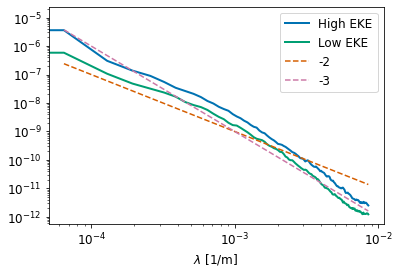

In [32]:
spice_spec_ztilde.sel(dives=slice(0,250)).mean('dives').plot(label='High EKE', linewidth=2)
spice_spec_ztilde.sel(dives=slice(250,500)).mean('dives').plot(label='Low EKE', linewidth=2)

kz = spice_spec_ztilde.freq_z_tilde

plt.plot(kz, 1e-15*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-18*kz**(-3), '--', label='-3')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

Text(0.5, 0, '$\\lambda$ [1/m]')

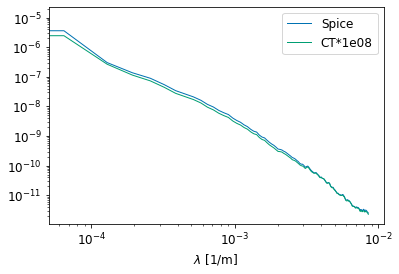

In [216]:
spice_spec_ztilde.sel(dives=slice(0,250)).mean('dives').plot(label='Spice', linewidth=1)
(2e-8*CT_spec_ztilde).sel(dives=slice(0,250)).mean('dives').plot(label='CT*1e08', linewidth=1)

kz = spice_spec_ztilde.freq_z_tilde

#plt.plot(kz, 1e-7*kz**(-2), '--', label='-2')
#plt.plot(kz, 1e-10*kz**(-3), '--', label='-3')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

As expected spice ius almost exactly like conservative temperature. Double check in final round to make sure that this is also true if alpha and beta are set to be depth dependent (instead of constants). 

#### Second approach 

Take spice from density to depth, **after** we have removed the waves. The signatures of waves are doing to be removed by some time filtering. 

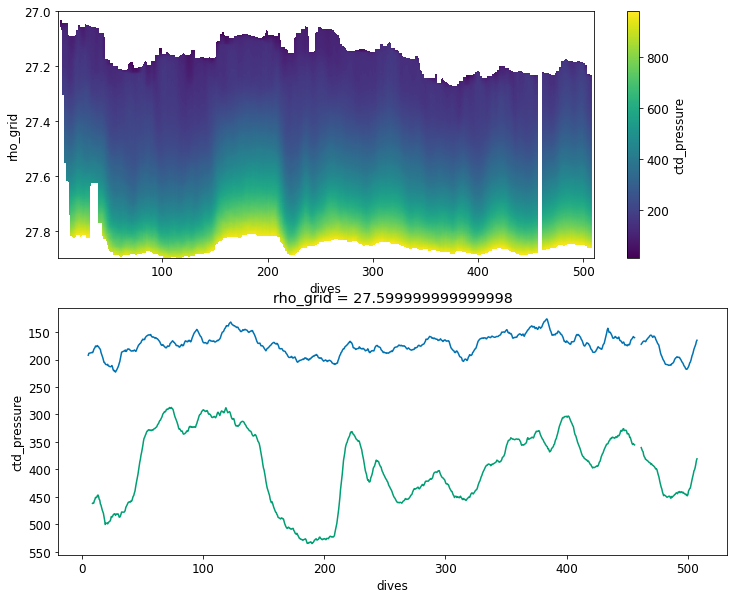

In [33]:
plt.figure(figsize=(12, 10))

sm_scale = 10
plt.subplot(211)
ds_660_rho.ctd_pressure.rolling(dives=sm_scale, center=True).mean().plot()
plt.gca().invert_yaxis()

plt.subplot(212)
ds_660_rho.ctd_pressure.rolling(dives=sm_scale, center=True).mean().sel(rho_grid=27.3, method='nearest').plot()
ds_660_rho.ctd_pressure.rolling(dives=sm_scale, center=True).mean().sel(rho_grid=27.6, method='nearest').plot()
plt.gca().invert_yaxis()


In [34]:
ds_660_rho.copy()

<xarray.Dataset>
Dimensions:       (dives: 1007, rho_grid: 901)
Coordinates:
  * rho_grid      (rho_grid) float64 27.0 27.0 27.0 27.0 ... 27.9 27.9 27.9 27.9
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    ctd_pressure  (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    CT            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    SA            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    latitude      (rho_grid, dives) float64 ...
    longitude     (rho_grid, dives) float64 ...
    days          (rho_grid, dives) float64 ...
    Spice         (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan

In [35]:
zsmooth = ds_660_rho.ctd_pressure.rolling(dives=sm_scale, center=True).mean()
ds_smooth = ds_660_rho.copy()
ds_smooth['ctd_pressure'] = zsmooth

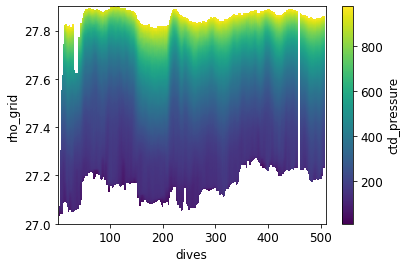

In [36]:
ds_smooth.ctd_pressure.plot()

In [37]:
dive_ind = 0
spice_zsmooth_xr= func_var_int_rho_to_z(ds_smooth.isel(dives=dive_ind), 'Spice')

for dive_ind in range(1, len(ds_smooth.dives)):
    spice_zsmooth_xr= xr.concat([spice_zsmooth_xr, 
                                 func_var_int_rho_to_z(ds_smooth.isel(dives=dive_ind), 'Spice')], 
                                 dim='dives')
    

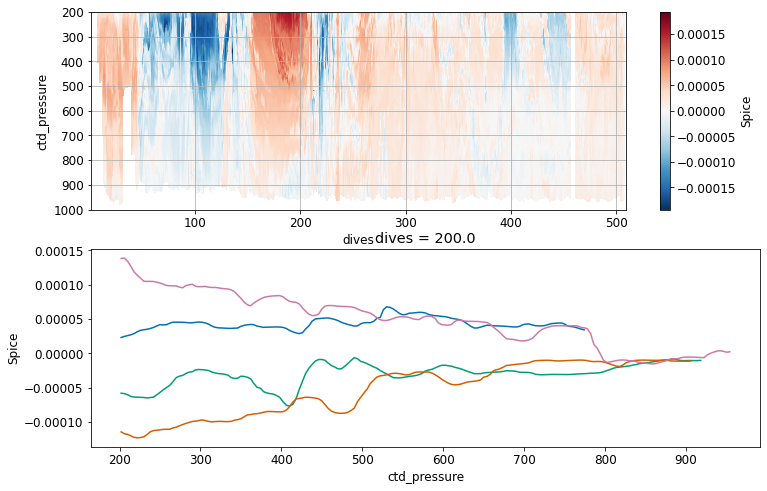

In [38]:
plt.figure(figsize=(12,8))

plt.subplot(211)
spice_zsmooth_xr.sel(ctd_pressure=slice(200,1000)).plot()
plt.grid()
plt.gca().invert_yaxis()

plt.subplot(212)
#ds_660_rho.Spice.plot()
spice_zsmooth_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=40).plot()
spice_zsmooth_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=80).plot()
spice_zsmooth_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=120).plot()
spice_zsmooth_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=200).plot()

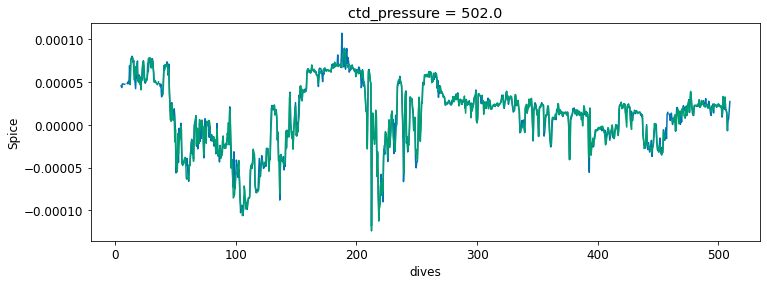

In [39]:
plt.figure(figsize=(12, 4))
spice_z_xr.sel(ctd_pressure=500, method='nearest').plot()
spice_zsmooth_xr.sel(ctd_pressure=500, method='nearest').plot()
# notice that spice is so rough that removing waves has little difference visually. 

In [40]:
ds_660_grid['Spice_smooth'] = spice_zsmooth_xr

In [41]:
# Interpolate to Ztilde
dive_ind = 0
spice_smooth_tilde_xr = func_var_ztilde_int(ds_660_grid.isel(dives=dive_ind), 'Spice_smooth')

for dive_ind in range(1, len(ds_660_grid.dives)):
    if np.mod(dive_ind, 100)==0:
        print(dive_ind)
    spice_smooth_tilde_xr = xr.concat([spice_smooth_tilde_xr , 
                                func_var_ztilde_int(ds_660_grid.isel(dives=dive_ind), 'Spice_smooth')], 
                               dim='dives')
    
    

100
200
300
400
500
600
700
800
900
1000


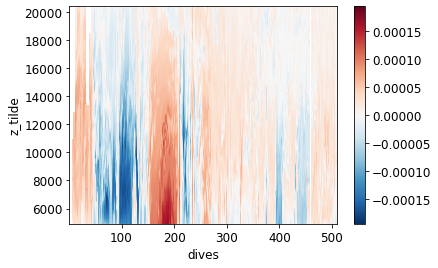

In [42]:
spice_smooth_tilde_xr.plot()

In [43]:
spice_smooth_spec_ztilde = xrft.power_spectrum(spice_smooth_tilde_xr.dropna(dim='dives') - 
                                        spice_smooth_tilde_xr.mean('dives'),
                                     dim='z_tilde', window=True)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


(1e-14, 1e-05)

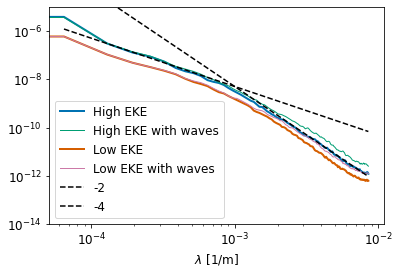

In [44]:
spice_smooth_spec_ztilde.sel(dives=slice(0,250)).mean('dives').plot(label='High EKE', linewidth=2)
spice_spec_ztilde.sel(dives=slice(0,250)).mean('dives').plot(label='High EKE with waves', linewidth=1)
spice_smooth_spec_ztilde.sel(dives=slice(250,500)).mean('dives').plot(label='Low EKE', linewidth=2)
spice_spec_ztilde.sel(dives=slice(250,500)).mean('dives').plot(label='Low EKE with waves', linewidth=1)

kz = spice_smooth_spec_ztilde.freq_z_tilde

plt.plot(kz, 5e-15*kz**(-2),  '--', label='-2',  color='k')
plt.plot(kz, 5e-21*kz**(-4),  '--', label='-4',  color='k')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')
plt.ylim([1e-14, 1e-5])

Removeing the waves does not change much at the larger scales, but at the smallest scales things get slightly smoother (going from about slope of -3.5 to -4). Maybe this is to be expected as the wave strain has been removed. 

#### 3rd approach 

Remove waves and also normalize. 

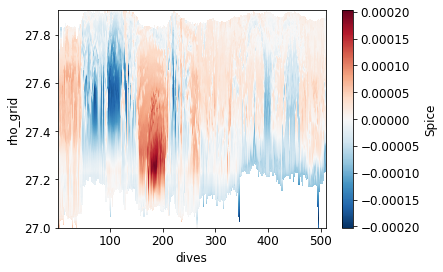

In [46]:
ds_smooth.Spice.plot()

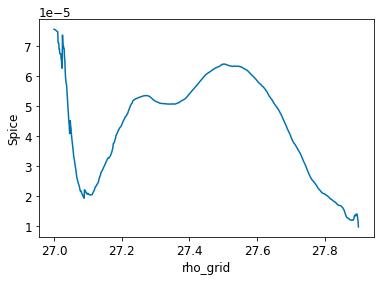

In [50]:
ds_smooth.Spice.std('dives').plot()

In [69]:
ds_smooth['Spice_norm']= ds_smooth['Spice']/ ds_smooth.Spice.var('dives')

In [70]:
dive_ind = 0
spice_zsmoothnorm_xr= func_var_int_rho_to_z(ds_smooth.isel(dives=dive_ind), 'Spice_norm')

for dive_ind in range(1, len(ds_smooth.dives)):
    spice_zsmoothnorm_xr= xr.concat([spice_zsmoothnorm_xr, 
                                 func_var_int_rho_to_z(ds_smooth.isel(dives=dive_ind), 'Spice_norm')], 
                                 dim='dives')
    

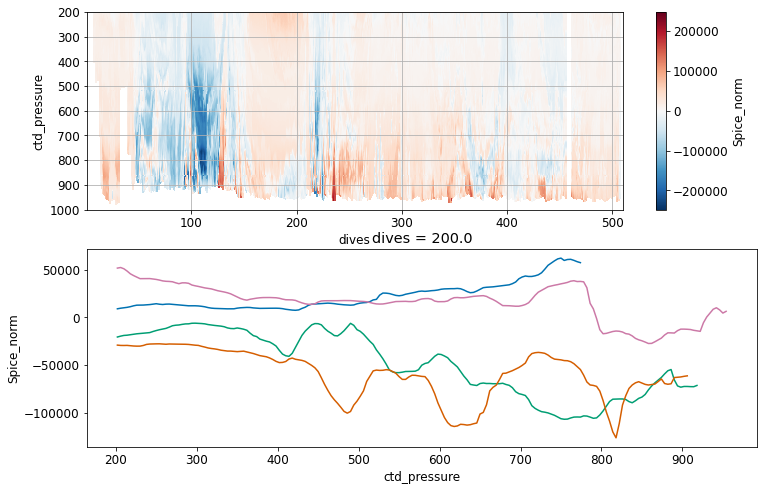

In [71]:
plt.figure(figsize=(12,8))

plt.subplot(211)
spice_zsmoothnorm_xr.sel(ctd_pressure=slice(200,1000)).plot()
plt.grid()
plt.gca().invert_yaxis()

plt.subplot(212)
#ds_660_rho.Spice.plot()
spice_zsmoothnorm_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=40).plot()
spice_zsmoothnorm_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=80).plot()
spice_zsmoothnorm_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=120).plot()
spice_zsmoothnorm_xr.sel(ctd_pressure=slice(200,1000)).sel(dives=200).plot()

In [72]:
ds_660_grid['Spice_smoothnorm'] = spice_zsmoothnorm_xr

In [73]:
# Interpolate to Ztilde
dive_ind = 0
spice_smoothnorm_tilde_xr = func_var_ztilde_int(ds_660_grid.isel(dives=dive_ind), 'Spice_smoothnorm')

for dive_ind in range(1, len(ds_660_grid.dives)):
    if np.mod(dive_ind, 100)==0:
        print(dive_ind)
    spice_smoothnorm_tilde_xr = xr.concat([spice_smoothnorm_tilde_xr , 
                                func_var_ztilde_int(ds_660_grid.isel(dives=dive_ind), 'Spice_smoothnorm')], 
                               dim='dives')
    
    

100
200
300
400
500
600
700
800
900
1000


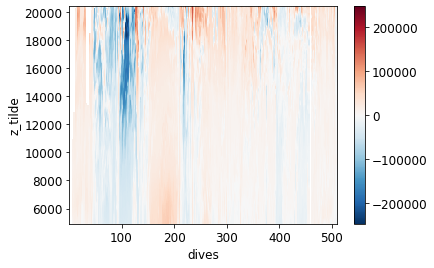

In [74]:
spice_smoothnorm_tilde_xr.plot()

In [75]:
spice_smoothnorm_spec_ztilde = xrft.power_spectrum(spice_smoothnorm_tilde_xr.dropna(dim='dives') - 
                                        spice_smoothnorm_tilde_xr.mean('dives'),
                                     dim='z_tilde', window=True)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


Text(0, 0.5, 'PSD')

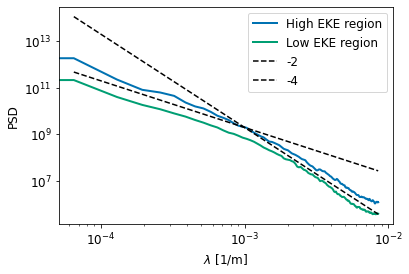

In [79]:
spice_smoothnorm_spec_ztilde.sel(dives=slice(0,250)).mean('dives').plot(label='High EKE region', linewidth=2)
#spice_spec_ztilde.sel(dives=slice(0,250)).mean('dives').plot(label='High EKE with waves', linewidth=1)
spice_smoothnorm_spec_ztilde.sel(dives=slice(250,500)).mean('dives').plot(label='Low EKE region', linewidth=2)
#spice_spec_ztilde.sel(dives=slice(250,500)).mean('dives').plot(label='Low EKE with waves', linewidth=1)

kz = spice_smoothnorm_spec_ztilde.freq_z_tilde

#plt.plot(kz, 2e-6*kz**(-2),  '--', label='-2',  color='k')
#plt.plot(kz, 2e-12*kz**(-4),  '--', label='-4',  color='k')

plt.plot(kz, 2e3*kz**(-2),  '--', label='-2',  color='k')
plt.plot(kz, 2e-3*kz**(-4),  '--', label='-4',  color='k')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')
plt.ylabel('PSD')
#plt.ylim([1e-4, 1e4])

Normalizing by the standard deviation or variance of the tracer does not change the spectral scaling.